# Original DataSet

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# The CSV file and its parameters

In [3]:
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)
df.head

<bound method NDFrame.head of        Run Number        phic     h_rain     alpha  \
0               1  899.706719  90.190740  0.000892   
1               2  899.799918  90.180419  0.000400   
2               3  899.827861  90.248562  0.000955   
3               4  899.887985  90.212106  0.000917   
4               5  899.871240  90.242351  0.000399   
...           ...         ...        ...       ...   
16030       16031  899.725398  90.235675  0.000964   
16031       16032  899.892179  90.192215  0.000651   
16032       16033  899.789632  90.245760  0.000611   
16033       16034  899.882513  90.173615  0.000779   
16034       16035  899.715613  90.210206  0.000681   

                                                Velocity  \
0      [[0.010799882501991228], [0.009855476258547132...   
1      [[0.01035123736773532], [0.008246628456653601]...   
2      [[0.009881864105294548], [0.008554994957547545...   
3      [[-0.0025341882699104813], [-0.000264394990128...   
4      [[0.0150617866

# The original given code for the new dataset

The NN model here consists of a sequential architect with three hidden layers, each using ReLU activation, and an output layer with a linear activation to produce continuing values. The model is trained to minimize mean squared error using the Adam optimizer.

In [8]:
random_seed = 42

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

# Shape: (num_samples, 3, 250)
input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

print(f"Number of training samples: {input_train.shape[0]}")
print(f"Number of testing samples: {input_test.shape[0]}")

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3, activation='linear'))
    return model

input_shape = (input_train_normalized.shape[1],)
nn_model = create_model(input_shape)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn_model.fit(input_train_normalized, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions_train_normalized = nn_model.predict(input_train_normalized)
nn_predictions_train = scaler_output.inverse_transform(nn_predictions_train_normalized)

nn_predictions_test_normalized = nn_model.predict(input_test_normalized)
nn_predictions_test = scaler_output.inverse_transform(nn_predictions_test_normalized)

lr_model = LinearRegression()
lr_model.fit(input_train_normalized, params_train_normalized)

lr_predictions_train_normalized = lr_model.predict(input_train_normalized)
lr_predictions_train = scaler_output.inverse_transform(lr_predictions_train_normalized)

lr_predictions_test_normalized = lr_model.predict(input_test_normalized)
lr_predictions_test = scaler_output.inverse_transform(lr_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

nn_errors_train = calculate_error(nn_predictions_train, params_train, bound_widths)
nn_errors_test = calculate_error(nn_predictions_test, params_test, bound_widths)

lr_errors_train = calculate_error(lr_predictions_train, params_train, bound_widths)
lr_errors_test = calculate_error(lr_predictions_test, params_test, bound_widths)

def calculate_mase(predictions, ground_truth):
    mase_values = []
    for i in range(predictions.shape[1]):
        naive_forecast = ground_truth[:-1, i]
        mae_naive = np.mean(np.abs(ground_truth[1:, i] - naive_forecast))
        mae_predictions = np.mean(np.abs(predictions[:, i] - ground_truth[:, i]))
        mase = mae_predictions / mae_naive
        mase_values.append(mase)
    return mase_values

nn_mase_train = calculate_mase(nn_predictions_train, params_train)
nn_mase_test = calculate_mase(nn_predictions_test, params_test)

lr_mase_train = calculate_mase(lr_predictions_train, params_train)
lr_mase_test = calculate_mase(lr_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Neural Network Errors (Train):", nn_errors_train)
print("Neural Network Errors (Test):", nn_errors_test)
print("Linear Regression Errors (Train):", lr_errors_train)
print("Linear Regression Errors (Test):", lr_errors_test)
print("Neural Network MASE (Train):", nn_mase_train)
print("Neural Network MASE (Test):", nn_mase_test)
print("Linear Regression MASE (Train):", lr_mase_train)
print("Linear Regression MASE (Test):", lr_mase_test)


Number of training samples: 12828
Number of testing samples: 3207


C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Neural Network Errors (Train): {'phic': 12.605628455701273, 'h_rain': 12.658154387503407, 'alpha': 12.889857127262314}
Neural Network Errors (Test): {'phic': 30.603384758647557, 'h_rain': 30.338436667232276, 'alpha': 30.43518798485399}
Linear Regression Errors (Train): {'phic': 23.91715841326829, 'h_rain': 24.077858915850907, 'alpha': 24.180259572647238}
Linear Regression Errors (Test): {'phic': 25.649218596490662, 'h_rain': 25.7463600069922, 'alpha': 25.58922486609742}
Neural Network MASE (Train): [0.3763319491039043, 0.37757761364342646, 0.3856400762017765]
Neural Network MASE (Test): [0.9194383389995237, 0.9229734648117783, 0.9031402797145143]
Linear Regression MASE (Train): [0.714029520568744, 0.71821374844861

# Visualizing the results

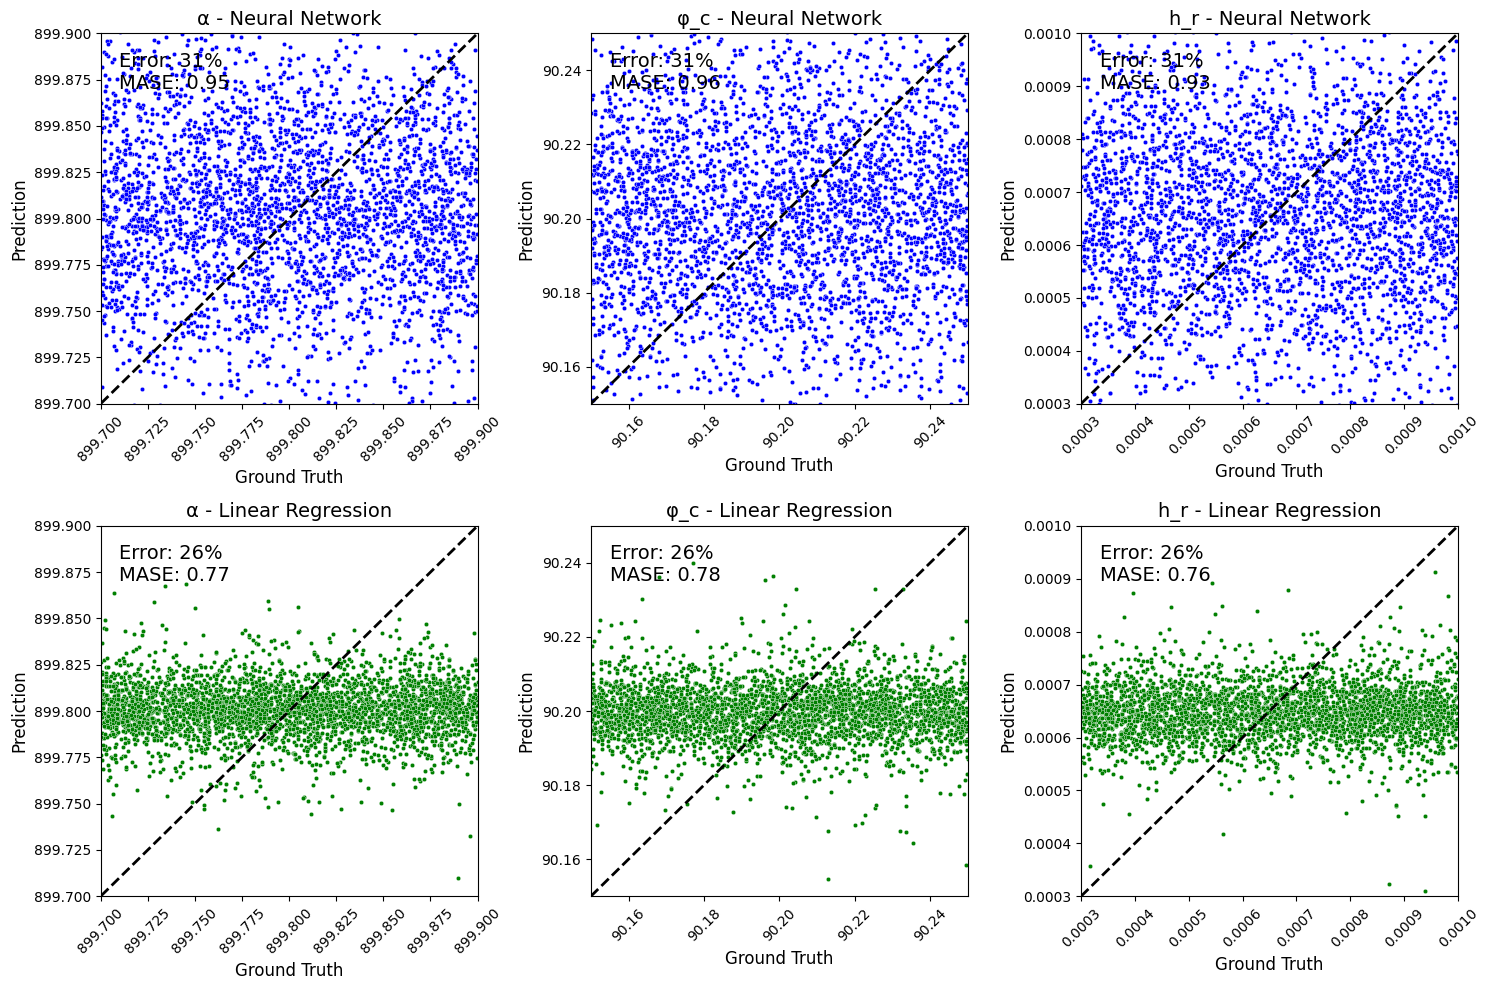

In [7]:
params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=nn_predictions_test[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Neural Network', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors_test[list(bounds.keys())[i]]
    mase = nn_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=lr_predictions_test[:, i], ax=axes[1, i], color='green', s=10)
    axes[1, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Linear Regression', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = lr_errors_test[list(bounds.keys())[i]]
    mase = lr_mase_test[i]
    axes[1, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Here we can see that both NN and the Linear Regression models are doing quite bad for predicting the our parameters. Interestingly, for linear regression it mainly predicts between a specific values (ex: 0.0005-0.0008) while NN is scattered around the whole graph and is not consistent with the original set

# Standart Scaler

Now we will do the same process again but this time using Standart Scaler. Using a Standard Scaler ensures that the input data has a mean of 0 and a standard deviation of 1, which improves the performance and convergence speed of the neural network and linear regression models.

z=σ/
x−μ

Number of training samples: 12828
Number of testing samples: 3207


C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Neural Network Errors (Train): {'phic': 11.81220474218926, 'h_rain': 11.660333584316156, 'alpha': 11.37657797950784}
Neural Network Errors (Test): {'phic': 31.4195055714978, 'h_rain': 31.323282336401938, 'alpha': 31.331917532867614}
Linear Regression Errors (Train): {'phic': 23.917158413268265, 'h_rain': 24.0778589158509, 'alpha': 24.180259572647238}
Linear Regression Errors (Test): {'phic': 25.649218596490662, 'h_rain': 25.746360006992163, 'alpha': 25.589224866097414}
Neural Network MASE (Train): [0.3526448561818384, 0.34781381189337385, 0.3403656344377705]
Neural Network MASE (Test): [0.9439576126193457, 0.9529350092891233, 0.929750024172946]
Linear Regression MASE (Train): [0.7140295205687434, 0.718213748448613

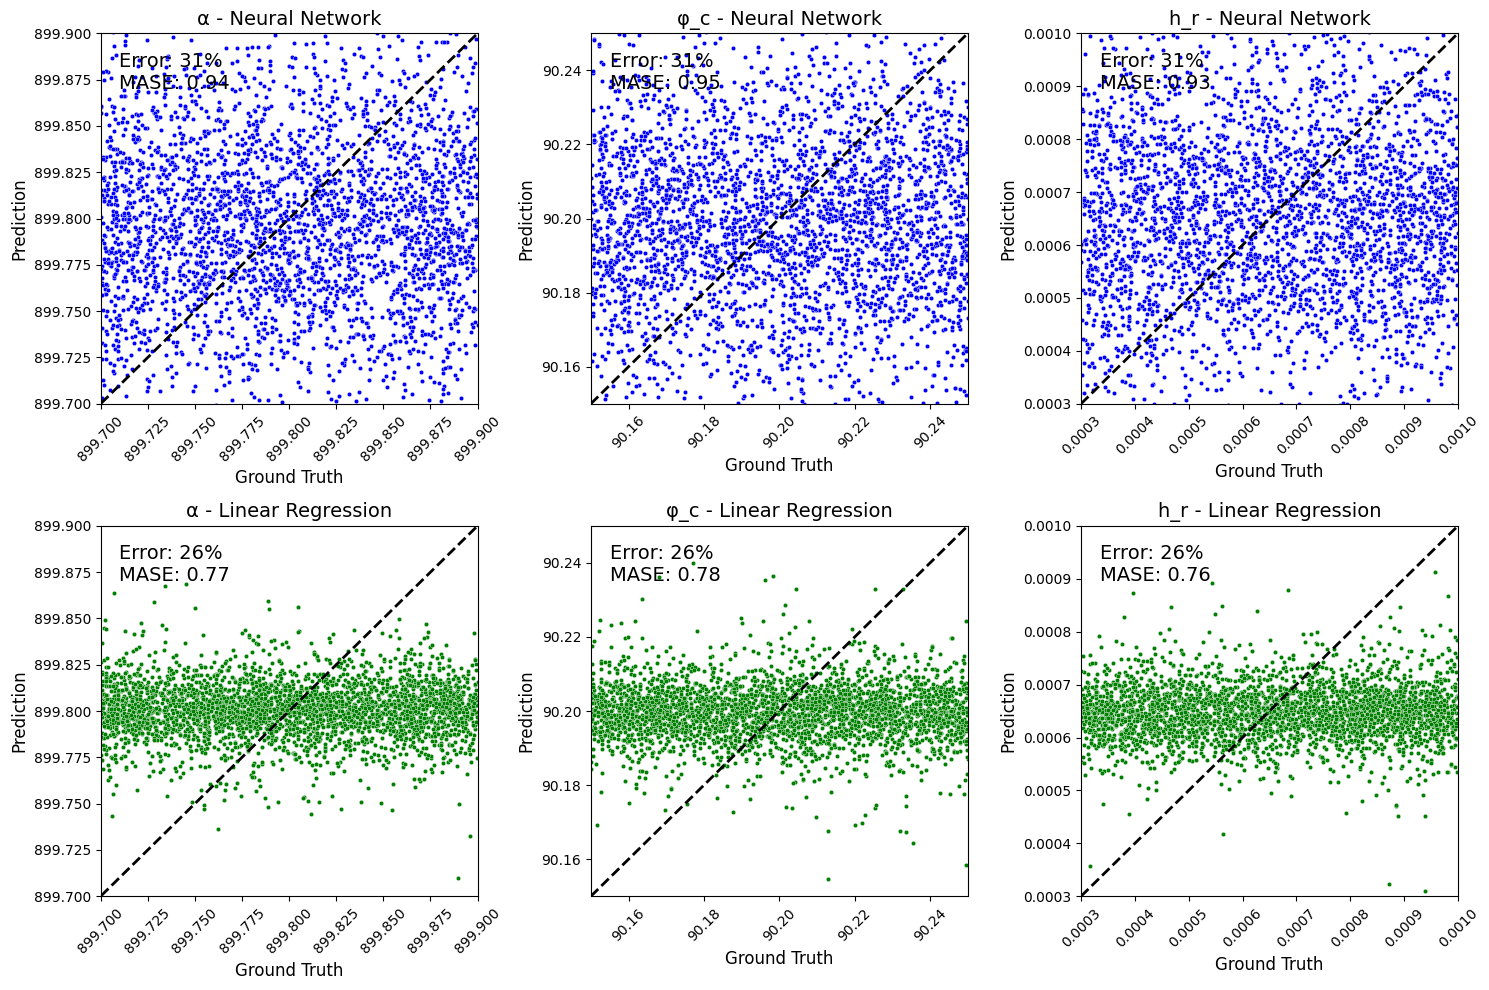

MASE for α (Train): Neural Network: 0.35, Linear Regression: 0.71
MASE for α (Test): Neural Network: 0.94, Linear Regression: 0.77
MASE for φ_c (Train): Neural Network: 0.35, Linear Regression: 0.72
MASE for φ_c (Test): Neural Network: 0.95, Linear Regression: 0.78
MASE for h_r (Train): Neural Network: 0.34, Linear Regression: 0.72
MASE for h_r (Test): Neural Network: 0.93, Linear Regression: 0.76


In [5]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models

random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

print(f"Number of training samples: {input_train.shape[0]}")
print(f"Number of testing samples: {input_test.shape[0]}")

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3, activation='linear'))
    return model

input_shape = (input_train_normalized.shape[1],)
nn_model = create_model(input_shape)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn_model.fit(input_train_normalized, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions_train_normalized = nn_model.predict(input_train_normalized)
nn_predictions_train = scaler_output.inverse_transform(nn_predictions_train_normalized)

nn_predictions_test_normalized = nn_model.predict(input_test_normalized)
nn_predictions_test = scaler_output.inverse_transform(nn_predictions_test_normalized)

lr_model = LinearRegression()
lr_model.fit(input_train_normalized, params_train_normalized)

lr_predictions_train_normalized = lr_model.predict(input_train_normalized)
lr_predictions_train = scaler_output.inverse_transform(lr_predictions_train_normalized)

lr_predictions_test_normalized = lr_model.predict(input_test_normalized)
lr_predictions_test = scaler_output.inverse_transform(lr_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

nn_errors_train = calculate_error(nn_predictions_train, params_train, bound_widths)
nn_errors_test = calculate_error(nn_predictions_test, params_test, bound_widths)

lr_errors_train = calculate_error(lr_predictions_train, params_train, bound_widths)
lr_errors_test = calculate_error(lr_predictions_test, params_test, bound_widths)

def calculate_mase(predictions, ground_truth):
    mase_values = []
    for i in range(predictions.shape[1]):
        naive_forecast = ground_truth[:-1, i]
        mae_naive = np.mean(np.abs(ground_truth[1:, i] - naive_forecast))
        mae_predictions = np.mean(np.abs(predictions[:, i] - ground_truth[:, i]))
        mase = mae_predictions / mae_naive
        mase_values.append(mase)
    return mase_values

nn_mase_train = calculate_mase(nn_predictions_train, params_train)
nn_mase_test = calculate_mase(nn_predictions_test, params_test)

lr_mase_train = calculate_mase(lr_predictions_train, params_train)
lr_mase_test = calculate_mase(lr_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Neural Network Errors (Train):", nn_errors_train)
print("Neural Network Errors (Test):", nn_errors_test)
print("Linear Regression Errors (Train):", lr_errors_train)
print("Linear Regression Errors (Test):", lr_errors_test)
print("Neural Network MASE (Train):", nn_mase_train)
print("Neural Network MASE (Test):", nn_mase_test)
print("Linear Regression MASE (Train):", lr_mase_train)
print("Linear Regression MASE (Test):", lr_mase_test)

# Visualization
params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Neural Network
for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=nn_predictions_test[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Neural Network', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors_test[list(bounds.keys())[i]]
    mase = nn_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=lr_predictions_test[:, i], ax=axes[1, i], color='green', s=10)
    axes[1, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Linear Regression', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = lr_errors_test[list(bounds.keys())[i]]
    mase = lr_mase_test[i]
    axes[1, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

for i, param in enumerate(params):
    print(f"MASE for {param} (Train): Neural Network: {nn_mase_train[i]:.2f}, Linear Regression: {lr_mase_train[i]:.2f}")
    print(f"MASE for {param} (Test): Neural Network: {nn_mase_test[i]:.2f}, Linear Regression: {lr_mase_test[i]:.2f}")


There was a slight improvement in Linear Regression, however no change was seen on NN for standart scaler

# Min Max

Min Max scales the data to a specified range (0 to 1), ensures that all features have the same scale

C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Neural Network Errors (Train): {'phic': 24.346112038009178, 'h_rain': 24.504316948472464, 'alpha': 24.442620204451345}
Neural Network Errors (Test): {'phic': 25.338765043165008, 'h_rain': 25.3316915674618, 'alpha': 25.53891629589814}
Neural Network MASE (Train): [0.7268356217672061, 0.7309344817677838, 0.7312768345802221]
Neural Network MASE (Test): [0.761269781997029, 0.7706553700183288, 0.7578472660842894]
Linear Regression Errors (Train): {'phic': 23.917158413267988, 'h_rain': 24.077858915850932, 'alpha': 24.180259572647063}
Linear Regression Errors (Test): {'phic': 25.64921859649079, 'h_rain': 25.746360006991935, 'alpha': 25.58922486609759}
Linear Regression MASE (Train): [0.714029520568735, 0.7182137484486141, 0.

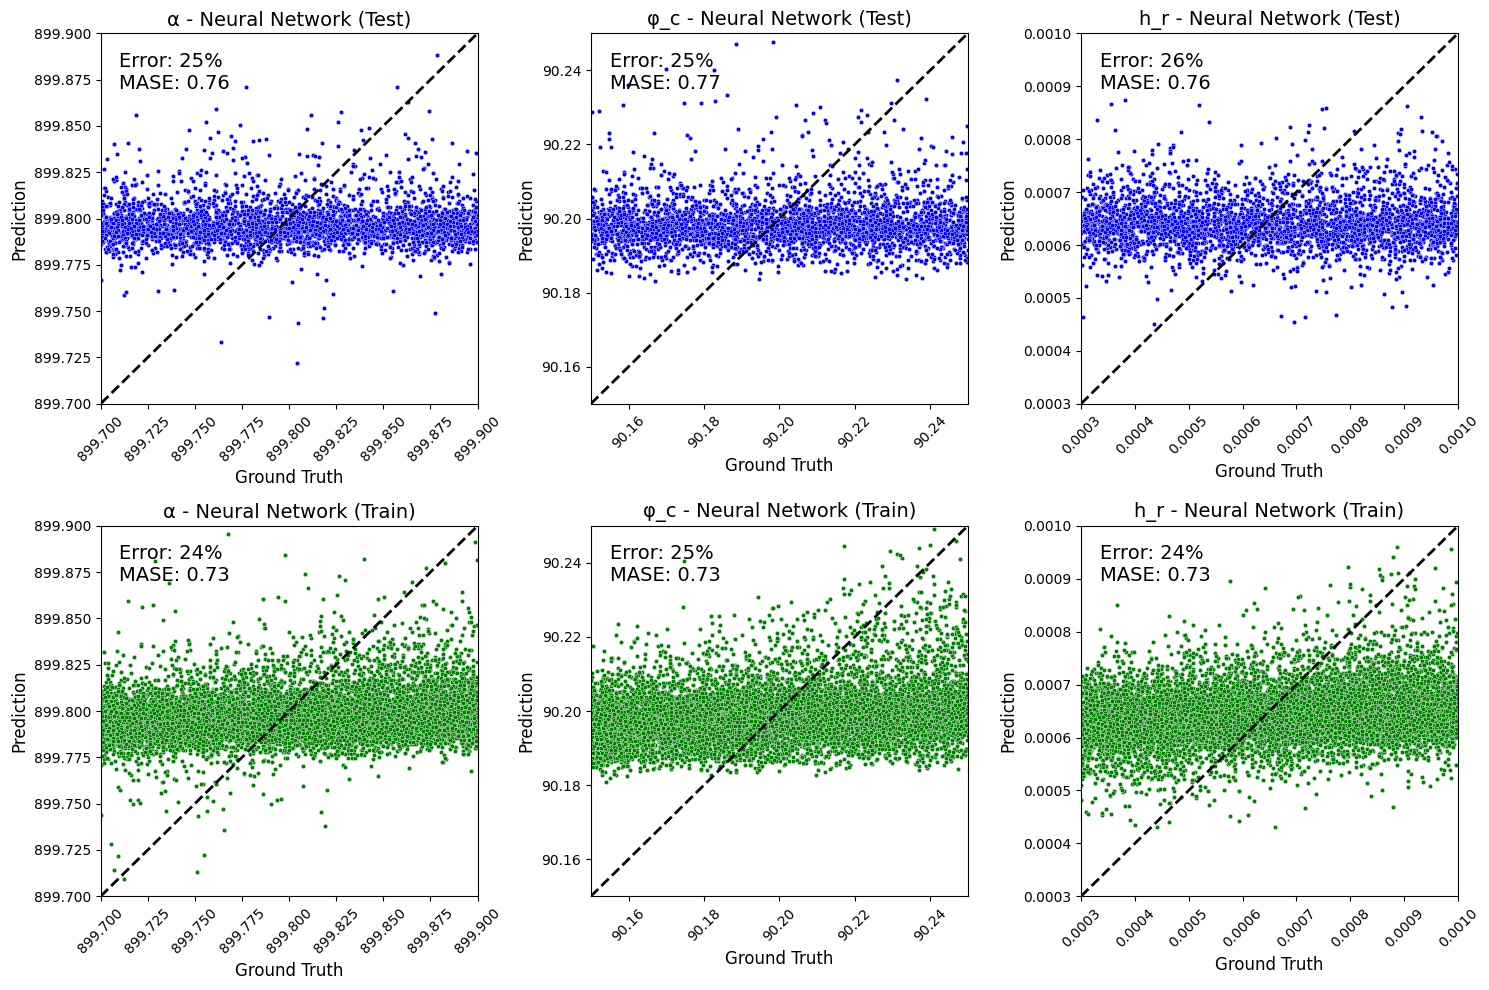

MASE for α (Train): 0.73
MASE for α (Test): 0.76
MASE for φ_c (Train): 0.73
MASE for φ_c (Test): 0.77
MASE for h_r (Train): 0.73
MASE for h_r (Test): 0.76


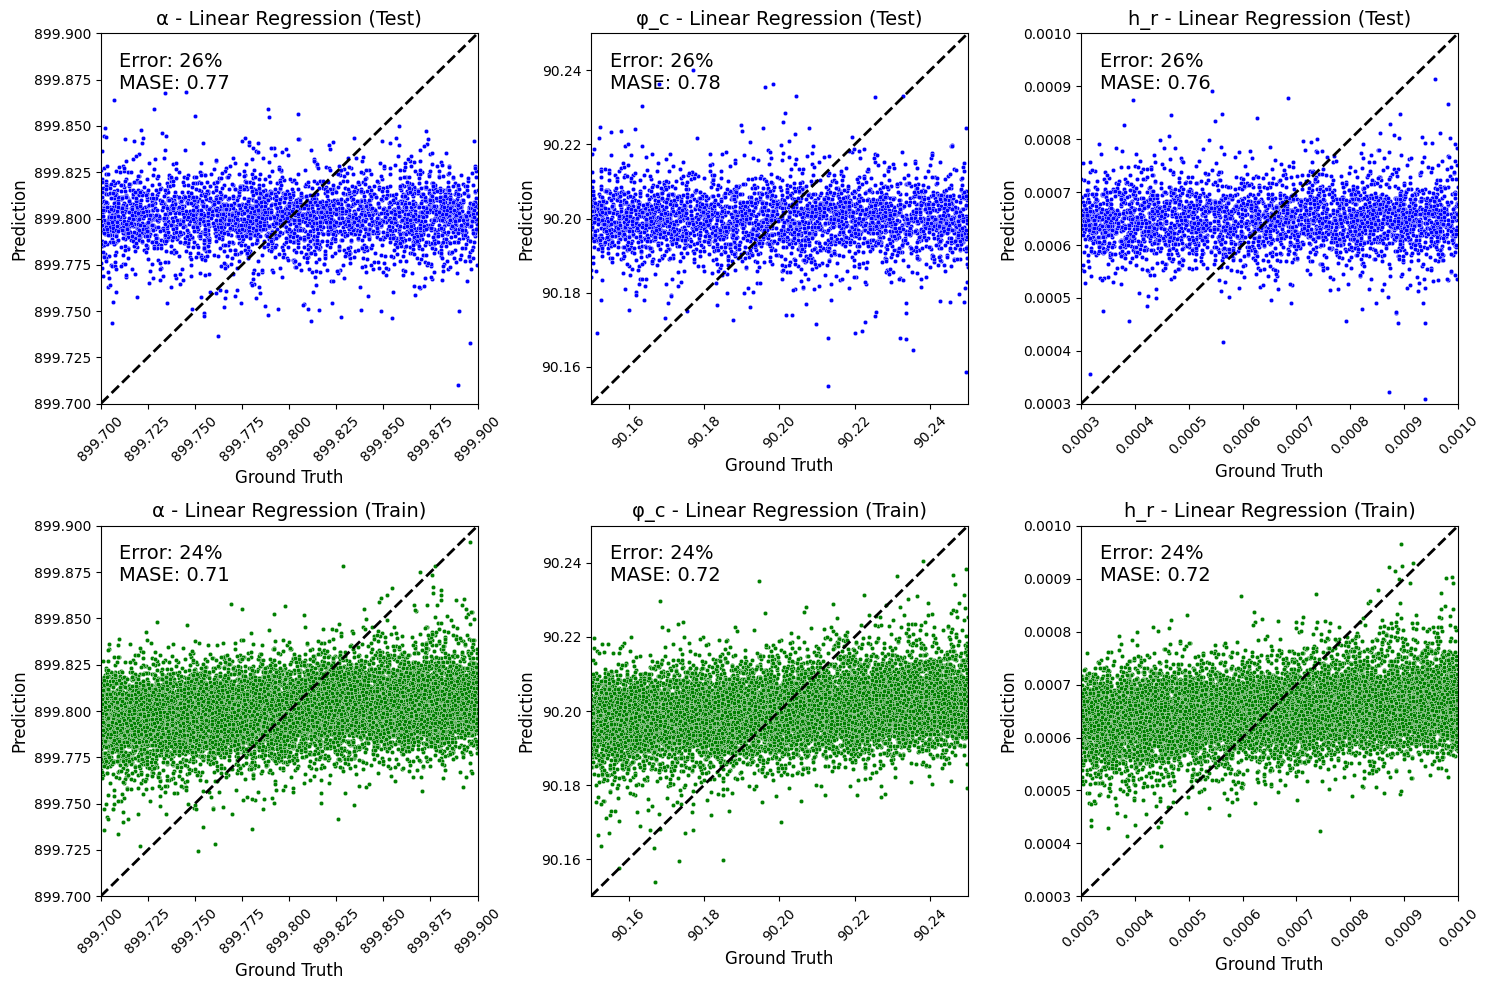

MASE for α (Train) - Linear Regression: 0.71
MASE for α (Test) - Linear Regression: 0.77
MASE for φ_c (Train) - Linear Regression: 0.72
MASE for φ_c (Test) - Linear Regression: 0.78
MASE for h_r (Train) - Linear Regression: 0.72
MASE for h_r (Test) - Linear Regression: 0.76


In [6]:
from sklearn.preprocessing import MinMaxScaler

random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

scaler_input = MinMaxScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = MinMaxScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3, activation='linear'))
    return model

input_shape = (input_train_normalized.shape[1],)
nn_model = create_model(input_shape)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn_model.fit(input_train_normalized, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions_train_normalized = nn_model.predict(input_train_normalized)
nn_predictions_train = scaler_output.inverse_transform(nn_predictions_train_normalized)

nn_predictions_test_normalized = nn_model.predict(input_test_normalized)
nn_predictions_test = scaler_output.inverse_transform(nn_predictions_test_normalized)

lr_model = LinearRegression()
lr_model.fit(input_train_normalized, params_train_normalized)

lr_predictions_train_normalized = lr_model.predict(input_train_normalized)
lr_predictions_train = scaler_output.inverse_transform(lr_predictions_train_normalized)

lr_predictions_test_normalized = lr_model.predict(input_test_normalized)
lr_predictions_test = scaler_output.inverse_transform(lr_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

def calculate_mase(predictions, ground_truth):
    mase_values = []
    for i in range(predictions.shape[1]):
        naive_forecast = ground_truth[:-1, i]
        mae_naive = np.mean(np.abs(ground_truth[1:, i] - naive_forecast))
        mae_predictions = np.mean(np.abs(predictions[:, i] - ground_truth[:, i]))
        mase = mae_predictions / mae_naive
        mase_values.append(mase)
    return mase_values

nn_errors_train = calculate_error(nn_predictions_train, params_train, bound_widths)
nn_errors_test = calculate_error(nn_predictions_test, params_test, bound_widths)
nn_mase_train = calculate_mase(nn_predictions_train, params_train)
nn_mase_test = calculate_mase(nn_predictions_test, params_test)

lr_errors_train = calculate_error(lr_predictions_train, params_train, bound_widths)
lr_errors_test = calculate_error(lr_predictions_test, params_test, bound_widths)
lr_mase_train = calculate_mase(lr_predictions_train, params_train)
lr_mase_test = calculate_mase(lr_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Neural Network Errors (Train):", nn_errors_train)
print("Neural Network Errors (Test):", nn_errors_test)
print("Neural Network MASE (Train):", nn_mase_train)
print("Neural Network MASE (Test):", nn_mase_test)
print("Linear Regression Errors (Train):", lr_errors_train)
print("Linear Regression Errors (Test):", lr_errors_test)
print("Linear Regression MASE (Train):", lr_mase_train)
print("Linear Regression MASE (Test):", lr_mase_test)

params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=nn_predictions_test[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Neural Network (Test)', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors_test[list(bounds.keys())[i]]
    mase = nn_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params):
    sns.scatterplot(x=params_train[:, i], y=nn_predictions_train[:, i], ax=axes[1, i], color='green', s=10)
    axes[1, i].plot([params_train[:, i].min(), params_train[:, i].max()], 
                    [params_train[:, i].min(), params_train[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Neural Network (Train)', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors_train[list(bounds.keys())[i]]
    mase = nn_mase_train[i]
    axes[1, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

for i, param in enumerate(params):
    print(f"MASE for {param} (Train): {nn_mase_train[i]:.2f}")
    print(f"MASE for {param} (Test): {nn_mase_test[i]:.2f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=lr_predictions_test[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Linear Regression (Test)', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = lr_errors_test[list(bounds.keys())[i]]
    mase = lr_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params):
    sns.scatterplot(x=params_train[:, i], y=lr_predictions_train[:, i], ax=axes[1, i], color='green', s=10)
    axes[1, i].plot([params_train[:, i].min(), params_train[:, i].max()], 
                    [params_train[:, i].min(), params_train[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Linear Regression (Train)', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = lr_errors_train[list(bounds.keys())[i]]
    mase = lr_mase_train[i]
    axes[1, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

for i, param in enumerate(params):
    print(f"MASE for {param} (Train) - Linear Regression: {lr_mase_train[i]:.2f}")
    print(f"MASE for {param} (Test) - Linear Regression: {lr_mase_test[i]:.2f}")


Even though no overfitting was recorded, we can see that there was a slight improvement in metrics however it came at a cost of NN model being more thinly ranged between a few data points, instead of being scattered better


<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><msub><mi>X</mi><mtext>scaled</mtext></msub><mo>=</mo><mfrac><mrow><mi>X</mi><mo>−</mo><msub><mi>X</mi><mtext>min</mtext></msub></mrow><mrow><msub><mi>X</mi><mtext>max</mtext></msub><mo>−</mo><msub><mi>X</mi><mtext>min</mtext></msub></mrow></mfrac></mrow><annotation encoding="application/x-tex">X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}} 
</annotation></semantics></math>


# Poly Degree 3


We did want to do more feature engineering and try with polynomial degrees 2 and if possible 3 but neither was able to implement to do storage/ram issues



In [33]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

scaler_input = MinMaxScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = MinMaxScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
input_train_poly = poly.fit_transform(input_train_normalized)
input_test_poly = poly.transform(input_test_normalized)

pca = PCA(n_components=2)  
input_train_pca = pca.fit_transform(input_train_poly)
input_test_pca = pca.transform(input_test_poly)

def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3, activation='linear'))
    return model

input_shape = (input_train_pca.shape[1],)
nn_model = create_model(input_shape)
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn_model.fit(input_train_pca, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions_normalized = nn_model.predict(input_test_pca)
nn_predictions = scaler_output.inverse_transform(nn_predictions_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

nn_errors = calculate_error(nn_predictions, params_test, bound_widths)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Neural Network Errors:", nn_errors)

params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=nn_predictions[:, i], ax=axes[i], color='blue', s=10)
    axes[i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                 [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[i].set_title(f'{param} - Neural Network', fontsize=14)
    axes[i].set_xlabel('Ground Truth', fontsize=12)
    axes[i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors[list(bounds.keys())[i]]
    axes[i].text(0.05, 0.95, f'{error:.0f}%', transform=axes[i].transAxes, fontsize=14, verticalalignment='top')
    axes[i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x0000020A390452A0>>
Traceback (most recent call last):
  File "C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel\ipkernel.py", line 783, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 


# PCA + Standart Scaler

Using a Standard Scaler before PCA ensures that all features contribute equally by having the same scale. PCA then reduces dimensionality by focusing on the most important features, improving model efficiency and performance.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block"><semantics><mrow><mi mathvariant="bold">C</mi><msub><mi mathvariant="bold">w</mi><mi>p</mi></msub><mo>≈</mo><msub><mi mathvariant="bold">x</mi><mi>p</mi></msub></mrow><annotation encoding="application/x-tex">\mathbf{C} \mathbf{w}_p \approx \mathbf{x}_p
</annotation></semantics></math>

Number of training samples: 12828
Number of testing samples: 3207


C:\Users\elshe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


401/401 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Neural Network Errors (Train) with PCA: {'phic': 24.854382545708344, 'h_rain': 25.01990667913588, 'alpha': 25.174372349465653}
Neural Network Errors (Test) with PCA: {'phic': 25.099976949959423, 'h_rain': 25.087569011184353, 'alpha': 25.251960812683937}
Linear Regression Errors (Train): {'phic': 23.91715841326829, 'h_rain': 24.077858915850907, 'alpha': 24.180259572647238}
Linear Regression Errors (Test): {'phic': 25.649218596490662, 'h_rain': 25.7463600069922, 'alpha': 25.58922486609742}
Neural Network MASE (Train) with PCA: [0.7420096713202805, 0.7463139070902574, 0.753169470796281]
Neural Network MASE (Test) with PCA: [0.7540957086217707, 0.7632285324367647, 0.7493320876827414]
Linear Regression MASE (Train): [0

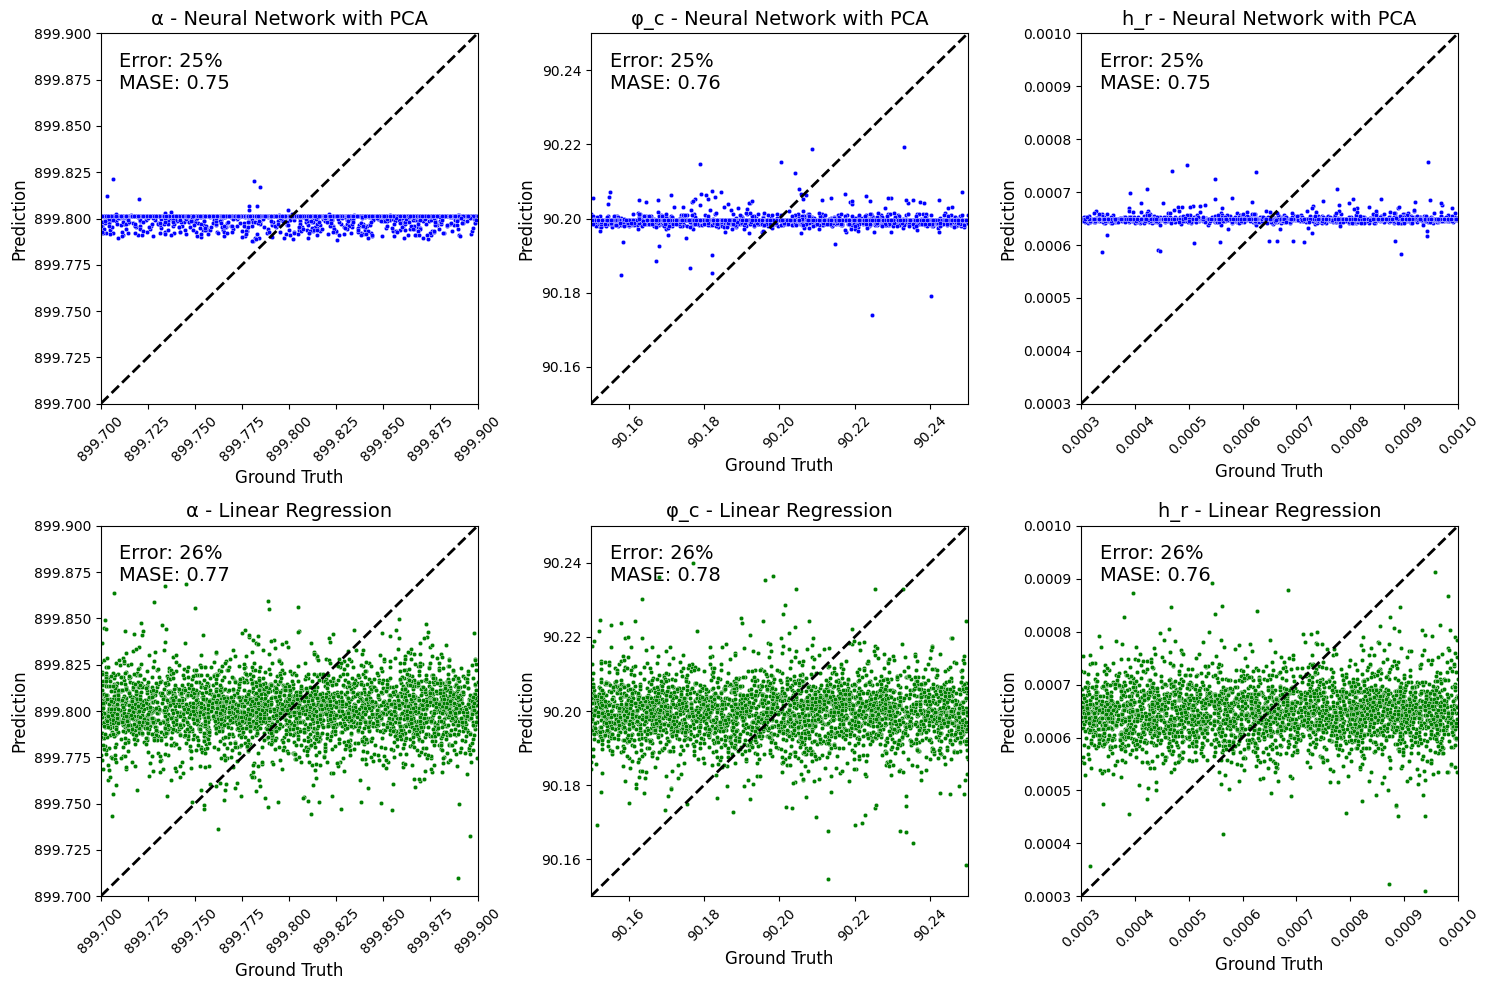

MASE for α (Train) with PCA: Neural Network: 0.74
MASE for α (Test) with PCA: Neural Network: 0.75
MASE for φ_c (Train) with PCA: Neural Network: 0.75
MASE for φ_c (Test) with PCA: Neural Network: 0.76
MASE for h_r (Train) with PCA: Neural Network: 0.75
MASE for h_r (Test) with PCA: Neural Network: 0.75


In [2]:
from sklearn.decomposition import PCA  

random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

print(f"Number of training samples: {input_train.shape[0]}")
print(f"Number of testing samples: {input_test.shape[0]}")

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

pca = PCA(n_components=2)

input_train_pca = pca.fit_transform(input_train_normalized)
input_test_pca = pca.transform(input_test_normalized)

def create_model(input_shape):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(3, activation='linear'))
    return model

input_shape_pca = (input_train_pca.shape[1],)  
nn_model_pca = create_model(input_shape_pca)
nn_model_pca.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
nn_model_pca.fit(input_train_pca, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

nn_predictions_train_normalized_pca = nn_model_pca.predict(input_train_pca)
nn_predictions_train_pca = scaler_output.inverse_transform(nn_predictions_train_normalized_pca)

nn_predictions_test_normalized_pca = nn_model_pca.predict(input_test_pca)
nn_predictions_test_pca = scaler_output.inverse_transform(nn_predictions_test_normalized_pca)

lr_model = LinearRegression()
lr_model.fit(input_train_normalized, params_train_normalized)

lr_predictions_train_normalized = lr_model.predict(input_train_normalized)
lr_predictions_train = scaler_output.inverse_transform(lr_predictions_train_normalized)

lr_predictions_test_normalized = lr_model.predict(input_test_normalized)
lr_predictions_test = scaler_output.inverse_transform(lr_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

nn_errors_train = calculate_error(nn_predictions_train_pca, params_train, bound_widths)
nn_errors_test = calculate_error(nn_predictions_test_pca, params_test, bound_widths)

lr_errors_train = calculate_error(lr_predictions_train, params_train, bound_widths)
lr_errors_test = calculate_error(lr_predictions_test, params_test, bound_widths)

def calculate_mase(predictions, ground_truth):
    mase_values = []
    for i in range(predictions.shape[1]):
        naive_forecast = ground_truth[:-1, i]
        mae_naive = np.mean(np.abs(ground_truth[1:, i] - naive_forecast))
        mae_predictions = np.mean(np.abs(predictions[:, i] - ground_truth[:, i]))
        mase = mae_predictions / mae_naive
        mase_values.append(mase)
    return mase_values

nn_mase_train = calculate_mase(nn_predictions_train_pca, params_train)
nn_mase_test = calculate_mase(nn_predictions_test_pca, params_test)

lr_mase_train = calculate_mase(lr_predictions_train, params_train)
lr_mase_test = calculate_mase(lr_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Neural Network Errors (Train) with PCA:", nn_errors_train)
print("Neural Network Errors (Test) with PCA:", nn_errors_test)
print("Linear Regression Errors (Train):", lr_errors_train)
print("Linear Regression Errors (Test):", lr_errors_test)
print("Neural Network MASE (Train) with PCA:", nn_mase_train)
print("Neural Network MASE (Test) with PCA:", nn_mase_test)
print("Linear Regression MASE (Train):", lr_mase_train)
print("Linear Regression MASE (Test):", lr_mase_test)

params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# nn with PCA
for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=nn_predictions_test_pca[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Neural Network with PCA', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = nn_errors_test[list(bounds.keys())[i]]
    mase = nn_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

# linreg (without PCA)
for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=lr_predictions_test[:, i], ax=axes[1, i], color='green', s=10)
    axes[1, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Linear Regression', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = lr_errors_test[list(bounds.keys())[i]]
    mase = lr_mase_test[i]
    axes[1, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

for i, param in enumerate(params):
    print(f"MASE for {param} (Train) with PCA: Neural Network: {nn_mase_train[i]:.2f}")
    print(f"MASE for {param} (Test) with PCA: Neural Network: {nn_mase_test[i]:.2f}")


# Random Forest

Next, we tried with a decision tree model called Random Forest which works with independant trees

Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Random Forest Errors (Train): {'phic': 9.688384707929853, 'h_rain': 9.784855948075439, 'alpha': 9.806060994716589}
Random Forest MASE (Train): 0.29012475229376455
Random Forest Errors (Test): {'phic': 26.497797528111676, 'h_rain': 26.09863419154153, 'alpha': 26.6479409704088}
Random Forest MASE (Test): 0.7953850373686746
MASE for α (Train - RF): 0.29
MASE for α (Test - RF): 0.80
MASE for φ_c (Train - RF): 0.29
MASE for φ_c (Test - RF): 0.80
MASE for h_r (Train - RF): 0.29
MASE for h_r (Test - RF): 0.80


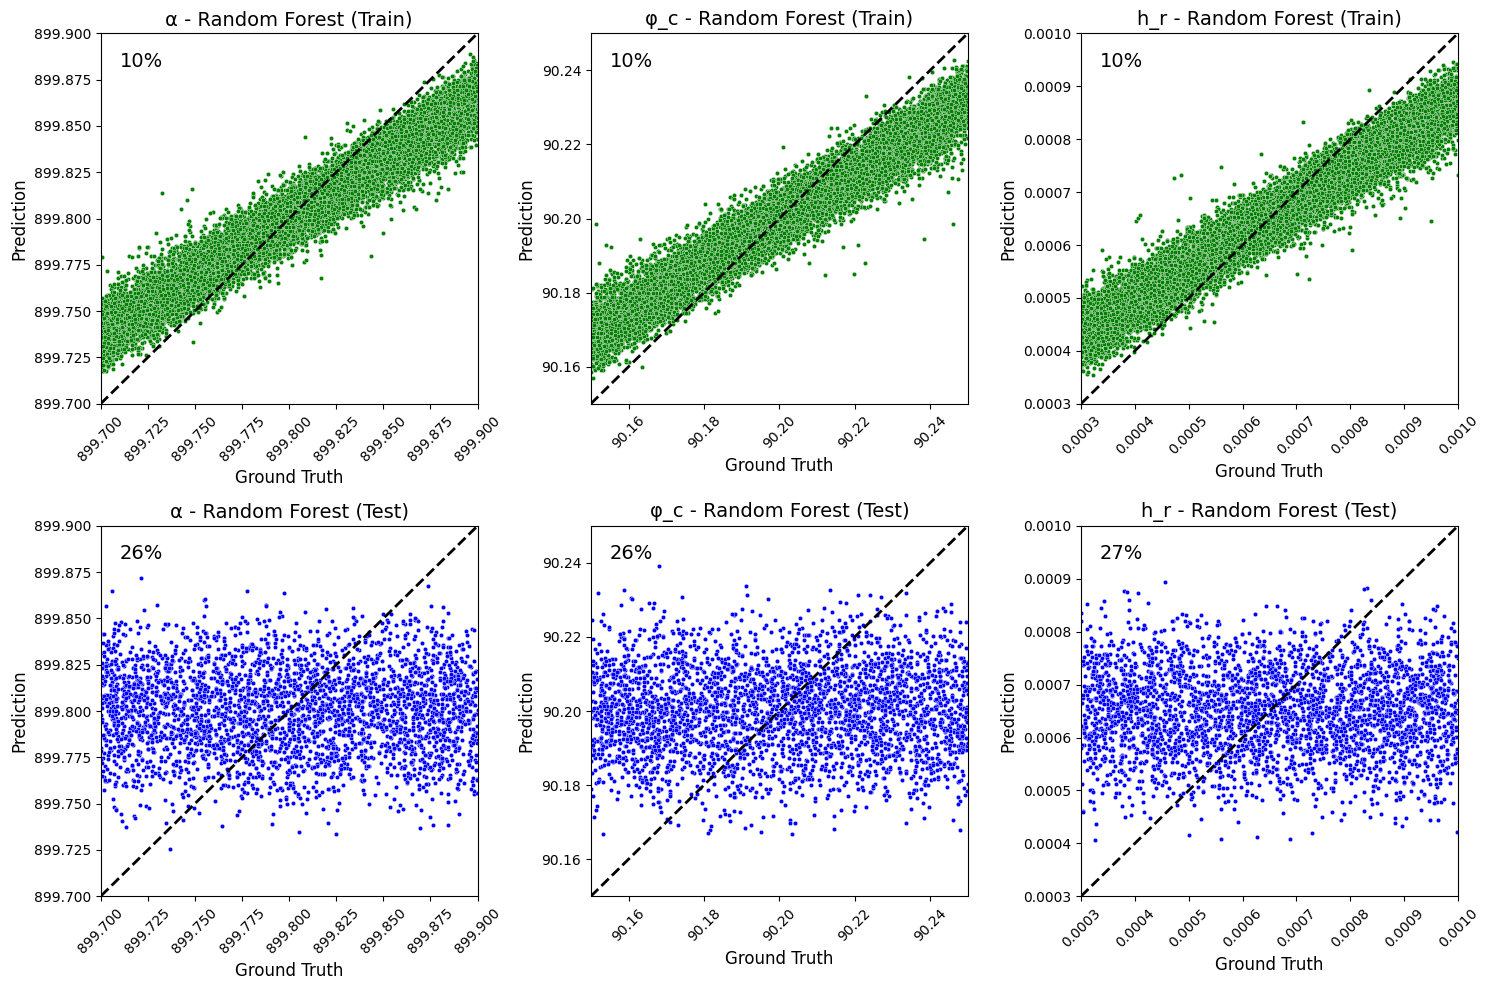

In [2]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

pca = PCA(n_components=2)  # Reduce number of components
input_train_pca = pca.fit_transform(input_train_normalized)
input_test_pca = pca.transform(input_test_normalized)

rf_model = RandomForestRegressor(n_estimators=100, random_state=random_seed)
rf_model.fit(input_train_pca, params_train_normalized)

rf_predictions_train_normalized = rf_model.predict(input_train_pca)
rf_predictions_train = scaler_output.inverse_transform(rf_predictions_train_normalized)

rf_predictions_test_normalized = rf_model.predict(input_test_pca)
rf_predictions_test = scaler_output.inverse_transform(rf_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param][1] - bounds[param][0]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

def calculate_mase(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    scale = np.mean(np.abs(np.diff(ground_truth, axis=0)))
    mase = np.mean(errors) / scale if scale != 0 else np.nan
    return mase

rf_errors_train = calculate_error(rf_predictions_train, params_train, bounds)
rf_mase_train = calculate_mase(rf_predictions_train, params_train)

rf_errors_test = calculate_error(rf_predictions_test, params_test, bounds)
rf_mase_test = calculate_mase(rf_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Random Forest Errors (Train):", rf_errors_train)
print("Random Forest MASE (Train):", rf_mase_train)
print("Random Forest Errors (Test):", rf_errors_test)
print("Random Forest MASE (Test):", rf_mase_test)

params_labels = ['α', 'φ_c', 'h_r']
for i, param in enumerate(params_labels):
    print(f"MASE for {param} (Train - RF): {rf_mase_train:.2f}")
    print(f"MASE for {param} (Test - RF): {rf_mase_test:.2f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params_labels):
    sns.scatterplot(x=params_train[:, i], y=rf_predictions_train[:, i], ax=axes[0, i], color='green', s=10)
    axes[0, i].plot([params_train[:, i].min(), params_train[:, i].max()], 
                     [params_train[:, i].min(), params_train[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Random Forest (Train)', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = rf_errors_train[list(bounds.keys())[i]]
    axes[0, i].text(0.05, 0.95, f'{error:.0f}%', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params_labels):
    sns.scatterplot(x=params_test[:, i], y=rf_predictions_test[:, i], ax=axes[1, i], color='blue', s=10)
    axes[1, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                     [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Random Forest (Test)', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = rf_errors_test[list(bounds.keys())[i]]
    axes[1, i].text(0.05, 0.95, f'{error:.0f}%', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


From here we can see that Random Forest did really well on train set and actually was able to find some of the needed patterns, however it did fail to predict on test set, showing clear sign of overfitting

# Comparing Results

  Parameter  MASE (Train - RF)  MASE (Test - RF)  MASE (Train - NN with PCA)  \
0         α               0.29               0.8                        0.74   
1       φ_c               0.29               0.8                        0.75   
2       h_r               0.29               0.8                        0.75   

   MASE (Test - NN with PCA)  MASE (Train - LR)  MASE (Test - LR)  
0                       0.75               0.71              0.77  
1                       0.76               0.72              0.78  
2                       0.75               0.72              0.76  


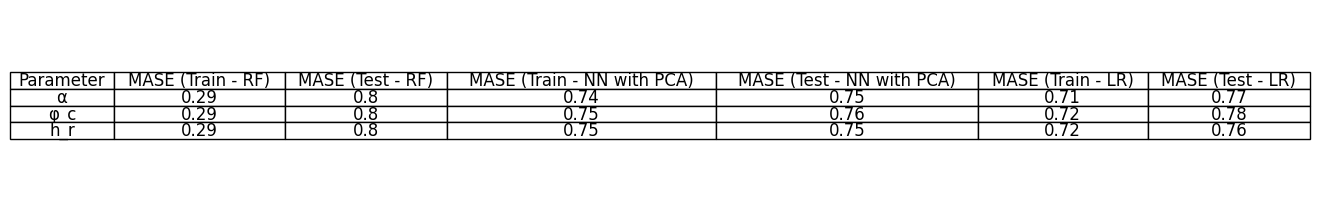

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Parameter': ['α', 'φ_c', 'h_r'],
    'MASE (Train - RF)': [0.29, 0.29, 0.29],
    'MASE (Test - RF)': [0.80, 0.80, 0.80],
    'MASE (Train - NN with PCA)': [0.74, 0.75, 0.75],
    'MASE (Test - NN with PCA)': [0.75, 0.76, 0.75],
    'MASE (Train - LR)': [0.71, 0.72, 0.72],
    'MASE (Test - LR)': [0.77, 0.78, 0.76]
}

df_mase = pd.DataFrame(data)


print(df_mase)

fig, ax = plt.subplots(figsize=(14, 2.5))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_mase.values, colLabels=df_mase.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(df_mase.columns))))

plt.show()


# GridSearch Random Forest

Because of the clear sign of overfitting, we decided to do a Gridsearch to find the best hyperparameters we can use to poentially make the test set better

Best parameters found:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validated score:  0.8678967250014292
Bounds: {'phic': (899.7, 899.9), 'h_rain': (90.15, 90.25), 'alpha': (0.0003, 0.001)}
Bound Widths: {'phic': 0.1999999999999318, 'h_rain': 0.09999999999999432, 'alpha': 0.0007000000000000001}
Random Forest Errors (Train): {'phic': 24.131026371471723, 'h_rain': 24.325490312639424, 'alpha': 24.47078441650804}
Random Forest MASE (Train): 0.7221671782650554
Random Forest Errors (Test): {'phic': 25.072560473049155, 'h_rain': 25.08914560926009, 'alpha': 25.263236116020504}
Random Forest MASE (Test): 0.7565626799983757
MASE for α (Train - RF): 0.72
MASE for α (Test - RF): 0.76
MASE for φ_c (Train - RF): 0.72
MASE for φ_c (Test - RF): 0.76
MASE for h_r (Train - RF): 0.72
MASE for h_r (Test - RF): 0.76


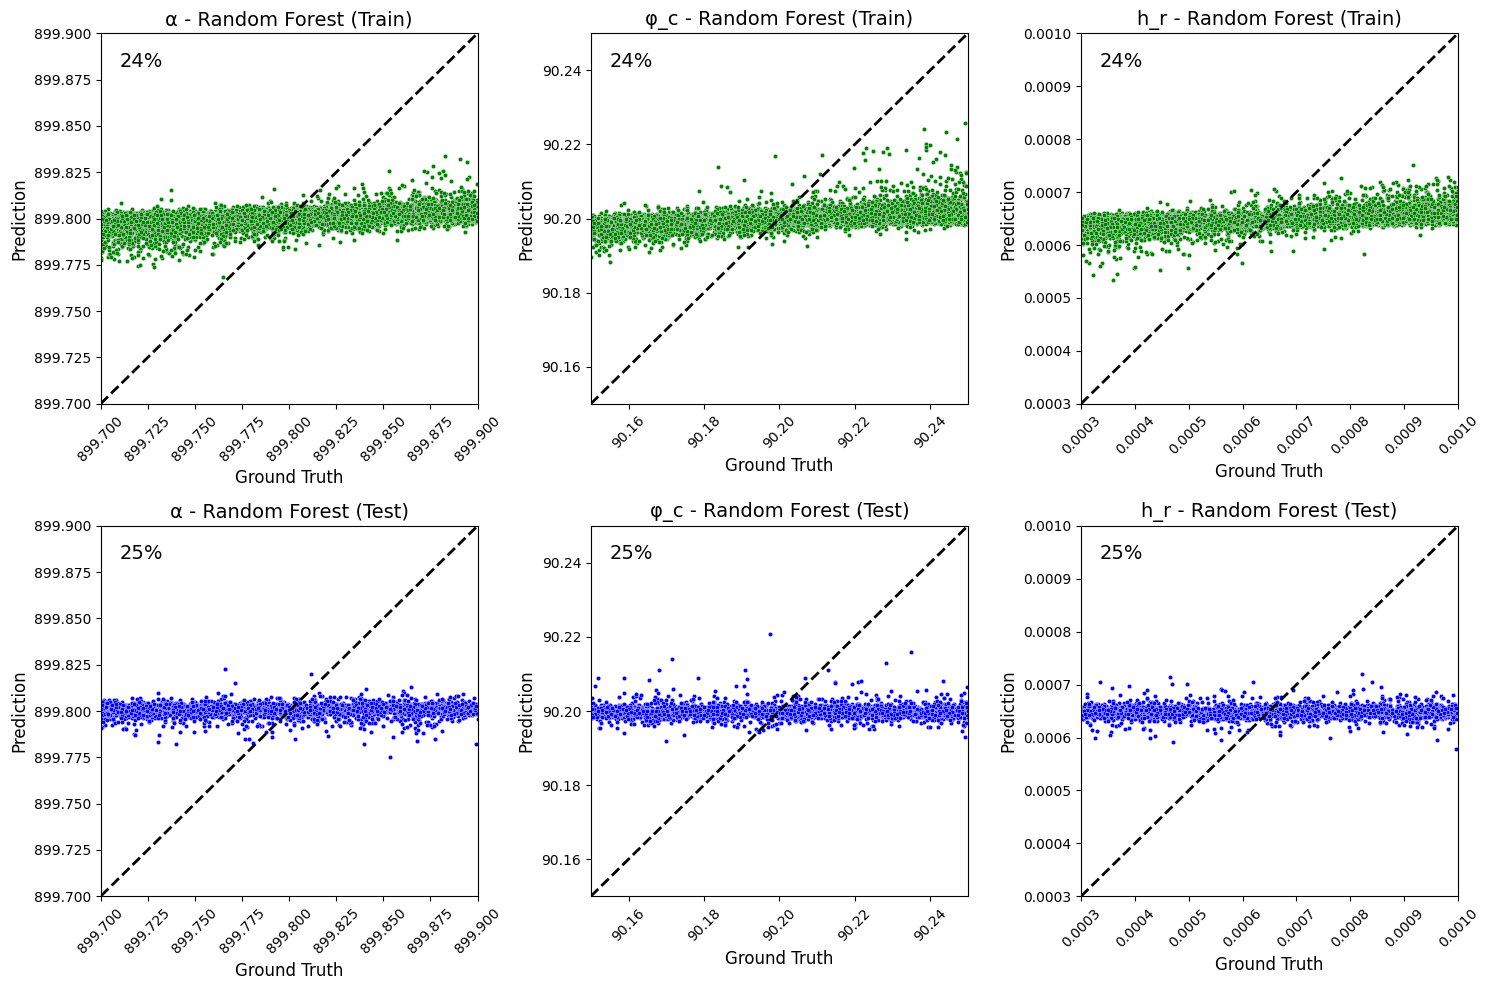

In [11]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42
file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=random_seed
)

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

pca = PCA(n_components=2)  # Reduce number of components
input_train_pca = pca.fit_transform(input_train_normalized)
input_test_pca = pca.transform(input_test_normalized)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=random_seed)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid_search.fit(input_train_pca, params_train_normalized)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validated score: ", -grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

rf_predictions_train_normalized = best_rf_model.predict(input_train_pca)
rf_predictions_train = scaler_output.inverse_transform(rf_predictions_train_normalized)

rf_predictions_test_normalized = best_rf_model.predict(input_test_pca)
rf_predictions_test = scaler_output.inverse_transform(rf_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param][1] - bounds[param][0]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

def calculate_mase(predictions, ground_truth):
    errors = np.abs(predictions - ground_truth)
    scale = np.mean(np.abs(np.diff(ground_truth, axis=0)))
    mase = np.mean(errors) / scale if scale != 0 else np.nan
    return mase

rf_errors_train = calculate_error(rf_predictions_train, params_train, bounds)
rf_mase_train = calculate_mase(rf_predictions_train, params_train)

rf_errors_test = calculate_error(rf_predictions_test, params_test, bounds)
rf_mase_test = calculate_mase(rf_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Random Forest Errors (Train):", rf_errors_train)
print("Random Forest MASE (Train):", rf_mase_train)
print("Random Forest Errors (Test):", rf_errors_test)
print("Random Forest MASE (Test):", rf_mase_test)

params_labels = ['α', 'φ_c', 'h_r']
for i, param in enumerate(params_labels):
    print(f"MASE for {param} (Train - RF): {rf_mase_train:.2f}")
    print(f"MASE for {param} (Test - RF): {rf_mase_test:.2f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params_labels):
    sns.scatterplot(x=params_train[:, i], y=rf_predictions_train[:, i], ax=axes[0, i], color='green', s=10)
    axes[0, i].plot([params_train[:, i].min(), params_train[:, i].max()], 
                     [params_train[:, i].min(),     params_train[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Random Forest (Train)', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = rf_errors_train[list(bounds.keys())[i]]
    axes[0, i].text(0.05, 0.95, f'{error:.0f}%', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

for i, param in enumerate(params_labels):
    sns.scatterplot(x=params_test[:, i], y=rf_predictions_test[:, i], ax=axes[1, i], color='blue', s=10)
    axes[1, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                     [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[1, i].set_title(f'{param} - Random Forest (Test)', fontsize=14)
    axes[1, i].set_xlabel('Ground Truth', fontsize=12)
    axes[1, i].set_ylabel('Prediction', fontsize=12)
    error = rf_errors_test[list(bounds.keys())[i]]
    axes[1, i].text(0.05, 0.95, f'{error:.0f}%', transform=axes[1, i].transAxes, fontsize=14, verticalalignment='top')
    axes[1, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[1, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


However, instead of improving the test set, gridsearch decreased it on the train set, we can see this from the chart too

# Bayesian with Tensorflow Probability

Using a Bayesian model is beneficial for SWE because it allows adding prior knowledge about parameters, which is crucial in environments with limited data or uncertain conditions. This approach provides more robust predictions by using uncertainties and updating as more data becomes available, enhancing the reliability of shallow water equations

In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

tf.random.set_seed(42)

file_MRZ = 'result_last_Maryam.csv'
df = pd.read_csv(file_MRZ)

parameters = df[['phic', 'h_rain', 'alpha']].to_numpy()

def process_column(column):
    column = column.apply(ast.literal_eval)
    column = column.apply(lambda x: np.array([item for sublist in x for item in sublist]))
    return np.vstack(column)

velocity = process_column(df['Velocity'])
height = process_column(df['Height'])
rain = process_column(df['Rain'])

input_data = np.hstack((velocity, height, rain))

input_train, input_test, params_train, params_test = train_test_split(
    input_data, parameters, test_size=0.2, random_state=42
)

print(f"Number of training samples: {input_train.shape[0]}")
print(f"Number of testing samples: {input_test.shape[0]}")

scaler_input = StandardScaler()
input_train_normalized = scaler_input.fit_transform(input_train)
input_test_normalized = scaler_input.transform(input_test)

scaler_output = StandardScaler()
params_train_normalized = scaler_output.fit_transform(params_train)
params_test_normalized = scaler_output.transform(params_test)

tfd = tfp.distributions

def create_bnn_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = tfp.layers.DenseReparameterization(128, activation='relu')(inputs)
    x = tfp.layers.DenseReparameterization(64, activation='relu')(x)
    x = tfp.layers.DenseReparameterization(32, activation='relu')(x)
    outputs = tfp.layers.DenseReparameterization(3)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = input_train_normalized.shape[1:]  # Adjusted input_shape
bnn_model = create_bnn_model(input_shape)

def negative_log_likelihood(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))


bnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=negative_log_likelihood)


history = bnn_model.fit(input_train_normalized, params_train_normalized, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

bnn_predictions_train_normalized = bnn_model.predict(input_train_normalized)
bnn_predictions_train = scaler_output.inverse_transform(bnn_predictions_train_normalized)

bnn_predictions_test_normalized = bnn_model.predict(input_test_normalized)
bnn_predictions_test = scaler_output.inverse_transform(bnn_predictions_test_normalized)

bounds = {
    'phic': (899.7, 899.9),
    'h_rain': (90.15, 90.25),
    'alpha': (0.0003, 0.001)
}
bound_widths = {key: bounds[key][1] - bounds[key][0] for key in bounds}

def calculate_error(predictions, ground_truth, bounds):
    errors = {}
    for i, param in enumerate(bounds):
        width = bounds[param]
        error = np.mean(np.abs((predictions[:, i] - ground_truth[:, i]) / width)) * 100
        errors[param] = error
    return errors

bnn_errors_train = calculate_error(bnn_predictions_train, params_train, bound_widths)
bnn_errors_test = calculate_error(bnn_predictions_test, params_test, bound_widths)

def calculate_mase(predictions, ground_truth):
    mase_values = []
    for i in range(predictions.shape[1]):
        naive_forecast = ground_truth[:-1, i]
        mae_naive = np.mean(np.abs(ground_truth[1:, i] - naive_forecast))
        mae_predictions = np.mean(np.abs(predictions[:, i] - ground_truth[:, i]))
        mase = mae_predictions / mae_naive
        mase_values.append(mase)
    return mase_values

bnn_mase_train = calculate_mase(bnn_predictions_train, params_train)
bnn_mase_test = calculate_mase(bnn_predictions_test, params_test)

print("Bounds:", bounds)
print("Bound Widths:", bound_widths)
print("Bayesian Neural Network Errors (Train):", bnn_errors_train)
print("Bayesian Neural Network Errors (Test):", bnn_errors_test)
print("Bayesian Neural Network MASE (Train):", bnn_mase_train)
print("Bayesian Neural Network MASE (Test):", bnn_mase_test)

params = ['α', 'φ_c', 'h_r']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(params):
    sns.scatterplot(x=params_test[:, i], y=bnn_predictions_test[:, i], ax=axes[0, i], color='blue', s=10)
    axes[0, i].plot([params_test[:, i].min(), params_test[:, i].max()], 
                    [params_test[:, i].min(), params_test[:, i].max()], 'k--', lw=2)
    axes[0, i].set_title(f'{param} - Bayesian Neural Network', fontsize=14)
    axes[0, i].set_xlabel('Ground Truth', fontsize=12)
    axes[0, i].set_ylabel('Prediction', fontsize=12)
    error = bnn_errors_test[list(bounds.keys())[i]]
    mase = bnn_mase_test[i]
    axes[0, i].text(0.05, 0.95, f'Error: {error:.0f}%\nMASE: {mase:.2f}', transform=axes[0, i].transAxes, fontsize=14, verticalalignment='top')
    axes[0, i].set_xlim(bounds[list(bounds.keys())[i]])
    axes[0, i].set_ylim(bounds[list(bounds.keys())[i]])
    axes[0, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Unfortunately we were not able to run this model due to problems in tensorflow library